# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- <b>Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.</b>

The dataset can be download here: https://figshare.com/collections/Soccer_match_event_dataset/4415000/2.

In [1]:
import json
import pandas as pd
import numpy as np
import pickle

from utils import *
from numpy import shape
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.model_selection import GridSearchCV
from keras.callbacks import Callback

import warnings
warnings.filterwarnings('ignore')

C:\Users\espos\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

### Preprocessing

The dataset is cleaned, removing the duels that occur during a match, as was done in the previous task.

In [4]:
for championship in events_df:
    if (championship == 'European_Championship') or (championship == 'World_Cup'):
        events_df[championship] = events_df[championship][events_df[championship]['matchPeriod'] != 'P']
    events_df[championship] = events_df[championship][(events_df[championship]['eventId'] != 1) & (~events_df[championship]['subEventId'].isin([11, 12]))].reset_index(drop=True)
    events_df[championship] = events_df[championship][(events_df[championship]['subEventName'] != 'Goal kick')].reset_index(drop=True)
    events_df[championship].drop(columns=['tags', 'eventName', 'subEventId', 'id'], inplace=True)

Furthermore, each initial position of an event is now transformed into a numerical value between 0 and 8. Each numerical value corresponds to a tile of the football field; the values of the tiles are visible in the graph below:

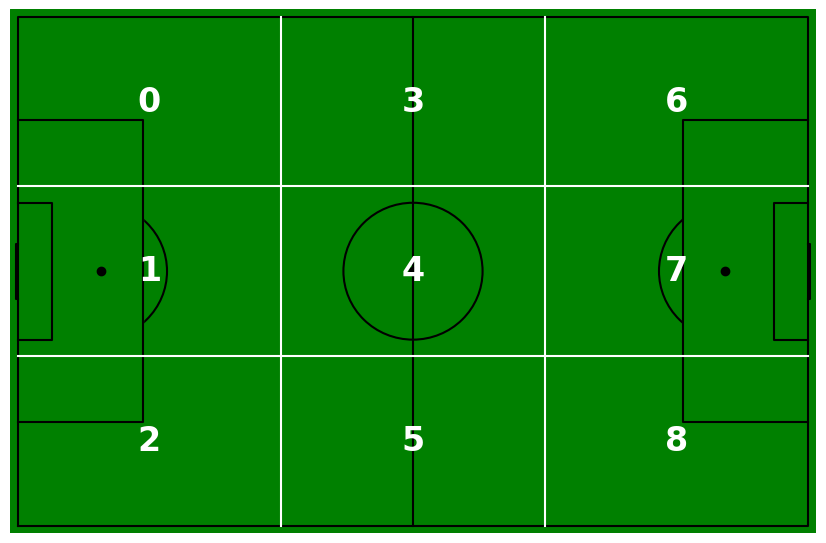

In [2]:
draw_tessellation()

In [6]:
events_df['France'].head()

,eventId,subEventName,playerId,positions,matchId,teamId,matchPeriod,eventSec
0,8,Simple pass,253784,"[{'y': 51, 'x': 50}, {'y': 46, 'x': 31}]",2500686,3799,1H,1.935181
1,8,High pass,29474,"[{'y': 46, 'x': 31}, {'y': 74, 'x': 68}]",2500686,3799,1H,3.599295
2,7,Touch,26389,"[{'y': 38, 'x': 30}, {'y': 40, 'x': 27}]",2500686,3772,1H,12.260977
3,7,Touch,26265,"[{'y': 80, 'x': 67}, {'y': 60, 'x': 73}]",2500686,3799,1H,13.344344
4,8,Simple pass,56441,"[{'y': 40, 'x': 27}, {'y': 40, 'x': 34}]",2500686,3772,1H,13.710413


In [7]:
for nation in nations:
    events_df[nation]['positions'] = events_df[nation]['positions'].apply(lambda x: from_coords_to_tesselation(x))
    events_df[nation].rename(columns={'positions': 'tessellation'}, inplace=True)

In [8]:
events_df['France'].head()

,eventId,subEventName,playerId,tessellation,matchId,teamId,matchPeriod,eventSec
0,8,Simple pass,253784,4,2500686,3799,1H,1.935181
1,8,High pass,29474,1,2500686,3799,1H,3.599295
2,7,Touch,26389,1,2500686,3772,1H,12.260977
3,7,Touch,26265,8,2500686,3799,1H,13.344344
4,8,Simple pass,56441,1,2500686,3772,1H,13.710413


The following code snippet calculates all the passing chains present in all the leagues present in the dataset. Subsequently, all passing chains with a length less than 3 will be eliminated from the created dictionary, thus trying to consider only more or less relevant passing chains.

In [9]:
pass_chains = {}

current_team_id = None
current_pass_chain = []
last_pass_event_index = {}

for nation in nations:
    for index, row in events_df[nation].iterrows():
        if row['eventId'] in [3, 8]:
            if row['teamId'] != current_team_id:
                if current_pass_chain:
                    pass_chains[index] = current_pass_chain
                current_team_id = row['teamId']
                current_pass_chain = [row['tessellation']]
                last_pass_event_index[current_team_id] = index
            else:
                current_pass_chain.append(row['tessellation'])
                last_pass_event_index[current_team_id] = index
        else:
            if row['teamId'] != current_team_id:
                if current_pass_chain:
                    pass_chains[last_pass_event_index[current_team_id]] = current_pass_chain
                current_team_id = row['teamId']
                current_pass_chain = []

if current_pass_chain:
    pass_chains[last_pass_event_index[current_team_id]] = current_pass_chain

In [10]:
# deletes the passes chains with less than 4 passes
pass_chains = [chain for chain in pass_chains.values() if len(chain) > 3]

### Recurrent Neural Network (RNN)

To quantify the predictability of passes made during a football match, it was decided to use a recurrent neural network.

Recurrent neural networks (RNNs) are able to learn dependencies between subsequent elements of a sequence and use these dependencies to make predictions or generate new data. RNNs are composed of a series of recurrent units, which are connected to each other in a cyclical manner. This allows the units to "remember" information from the previous elements of the sequence and use it to process the subsequent elements.

To use an RNN, it must first be trained. To train it, the data must be structured in a way that it can be fed into the model. To do this, a dummy value (9) is added to the beginning of each passing chain, so that all passing chains have the same length, equal to the maximum length of a passing chain. Subsequently, one-hot encoding is performed on these sequences that will need to be fed into the model.

In [11]:
# Determine maximum sequence length
max_length = max(len(seq) for seq in pass_chains)

# Pad sequences
padded_data = pad_sequences(pass_chains, maxlen=max_length, padding='pre', value=9)

# One-hot encode if needed (assuming the data is categorical)
one_hot_data = to_categorical(padded_data)

The entire dataset is then split vertically into two parts:

- X contains all the n-1 tiles of a passing chain

- y contains the n-th tile, where the ball will be located

Additionally, both X and y have been split into training and test sets.

In [12]:
X = one_hot_data[:, :-1, :]  # Features (input data)
y = one_hot_data[:, -1, :]   # Target variable (to be predicted)

# Split the data into training and test sets
num_samples = len(X)
train_size = int(0.8 * num_samples)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print('Shape of the training set:', shape(X_train))
print('Shape of the test set:', shape(X_test))
print('Shape of the training labels:', shape(y_train))
print('Shape of the test labels:', shape(y_test))

Shape of the training set: (84130, 82, 10)
Shape of the test set: (21033, 82, 10)
Shape of the training labels: (84130, 10)
Shape of the test labels: (21033, 10)


To find the best combination of hyperparameters for training the model, a grid search with cross-validation was used. This is why it was not necessary to generate a validation set in the previous step. In addition, the following function was defined to create the model object:

In [13]:
def create_model(neurons):
    model = Sequential()
    model.add(SimpleRNN(units=neurons[0], input_shape=(max_length-1, one_hot_data.shape[2]), return_sequences=True))
    model.add(SimpleRNN(units=neurons[1], input_shape=(max_length-1, one_hot_data.shape[2]), return_sequences=True))
    model.add(SimpleRNN(units=neurons[2], input_shape=(max_length-1, one_hot_data.shape[2])))
    model.add(Dense(units=y.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

A grid search was performed multiple times to find the most suitable number of epochs, batch size, number of layers, activation function and nodes within each layer to make the RNN model as accurate as possible with good generalization capabilities.

In [ ]:
#This is the grid search used to look for the best hyperparameters... it takes a lot of time to run :)
#The fine tuned parameters are: neurons and batch_size; however, a previous grid search was performed to find the best number of epochs
#and the best activation function for the output layer.
"""neurons = [[5, 10, 10], [10, 15, 15], [20, 15, 20], [30, 30, 50]]
batch_size = [160, 180]
param_grid = dict(neurons=neurons, batch_size=batch_size)

model = KerasClassifier(build_fn=create_model, epochs=32)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=5)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

In [15]:
# the best parameters are epochs=32, batch_size=160, neurons=[20, 15, 20], activation_function=softmax
#model = grid_result.best_estimator_

In [ ]:
"""model = KerasClassifier(build_fn=create_model, epochs=32, batch_size=160, neurons=[20, 15, 20])"""

In [ ]:
"""logs = Callback()"""

In [ ]:
"""history = model.fit(X_train, y_train, epochs=32, batch_size=180, verbose=0, callbacks=[logs])"""

In [ ]:
"""plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log') #log scale
plt.title('Learning Curve - Loss')
plt.legend()
plt.grid(True)
plt.show()"""

In [ ]:
"""plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yscale('log') #log scale
plt.title('Learning Curve - Accuracy')
plt.legend()
plt.grid(True)
plt.show()"""

In [ ]:
# to store the model
"""model_to_save = model.model
model_to_save.save('model.h5')"""

In [14]:
# to load the model
model = keras.models.load_model('model.h5')

#### Total accuracy on the test set

After finding the best combination of hyperparameters and training the model using the training set, its accuracy was measured, which recorded a value of 0.46. At first glance, this value might seem low, however there are a few points to discuss:

- The first point is that the problem addressed is a multi-class classification, which has a baseline of 1/9, approximately 0.11, and the obtained value from the trained model surpasses it by about 3 times.

- The second point is that there are different passing chains. For example, consider the case where a team is in the lead and has possession of the ball: this team will obviously try to keep possession of the ball as much as possible and will tend to keep it more in the defensive areas. On the contrary, a team that is losing and is in the last minutes of the game, will tend to make more long passes and crosses to try to bring the ball into the opponent's penalty area and score. There are different phases of play in football that lead to different situations and different passing chains. Probably, if these additional informations were added to the data of the dataset, the model could reach a higher accuracy value.

- The third point is that the model is not given as input, as a feature, whether the team that is making the passes is attacking towards the left or right side of the field. This point is quite important because, if a team attacks towards the right, the passes will tend to be made towards the tiles with the highest values; on the contrary, if the team attacking towards the left is in possession of the ball, then the ball will tend to be passed towards the tiles with the lowest values.

- The fourth point to consider is the playing style of each team. Each coach has their own playing philosophy which can drastically modify the passing patterns and ball circulation. In fact, there are coaches who prefer long passes and others who prefer short passes. By giving the RNN the playing style of a team as a feature, it would probably be possible to have a more accurate result on the prediction of the next pass.

- The last point is the unpredictability and subjectivity of football. This sport is played by people who know and study the tactics of their team, but they can also act on their own initiative and pass the ball into spaces on the field that are free at that moment, they may not notice movements of teammates who are not marked at that moment, they may make mistakes. How many times, for example, watching a football match, have we tried to predict where the player who has the ball at that moment would pass it in a specific pitch tile to a specific teammate, and it did not happen?

Below are some graphs that show how, even if the model does not correctly predict the next tile (therefore not assigning the highest probability to the actual tile, y), it usually assigns the second highest probability to the actual tile, which confirms that the model is able, more or less, to provide in order good probabilities and percentages on which will be the next tile in which the ball will be after a pass.

In [15]:
#in case you load the model, execute this line...
print('Accuracy on the test set (in percentage): %.2f' %(model.evaluate(X_test, y_test)[1]*100))

#otherwise this one!
#print('Accuracy on the training set (in percentage): %.2f' %(model.score(X_train, y_train)*100))

658/658 [==============================] - 12s 16ms/step - loss: 1.4641 - accuracy: 0.4645
Accuracy on the test set (in percentage): 46.45


#### Further analysis

##### Case 1

The first example shows how a prediction is made. In particular, the model is given a sequence of tiles as input, in this case 5 5 5 5 5 2, and it should predict that the next tile where the ball will be after a pass is 1. Indeed, as can be seen in the soccer field, the highest percentage is that of tile 1. In this case, therefore, the model has correctly predicted where the ball will be at the next pass.

In [16]:
decoded_indices = np.argmax(X_test[2], axis=1)

decoded_indices = decoded_indices[decoded_indices != 9]
print("Pass chain:", decoded_indices)

Pass chain: [5 5 5 5 5 2]


In [17]:
decoded_index = np.argmax(y_test[2], axis=0)

decoded_index = decoded_index[decoded_index != 9]
print("Expected result:", decoded_index)

Expected result: [1]


In [18]:
# in case you are using the loaded model, do not change the method, otherwise change it to "predict_probab"
predictions = model.predict(np.expand_dims(X_test[2], axis=0))

predictions = np.delete(predictions, -1)

prob = predictions.tolist()
prob = [round(x, 2) for x in prob]

1/1 [==============================] - 1s 713ms/step


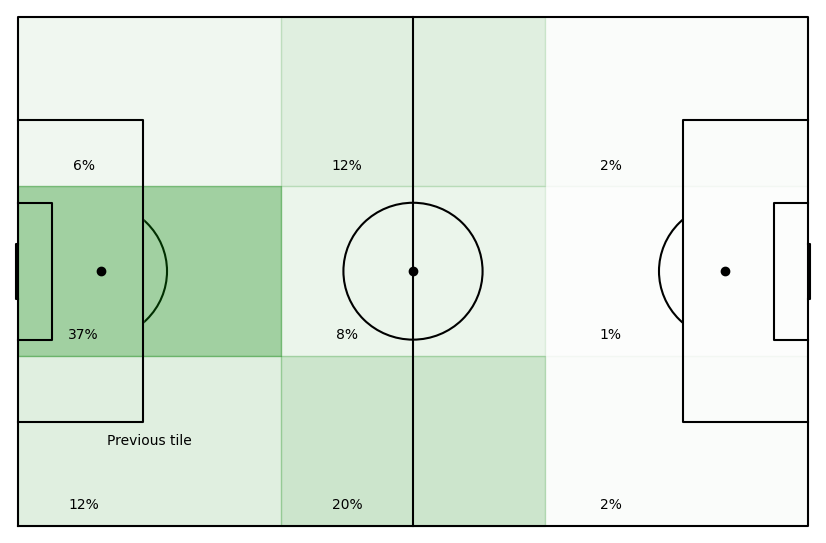

In [19]:
draw_pitch("white", "black", prob, decoded_indices[-1])

##### Case 2

This is another example of a correct prediction:

In [20]:
decoded_indices = np.argmax(X_test[9], axis=1)

decoded_indices = decoded_indices[decoded_indices != 9]
print("Pass chain:", decoded_indices)

Pass chain: [0 3 3 3 0 1 2 5 2 2 1 3]


In [21]:
# Find the index of the maximum value in each one-hot encoded vector (representing the original class)
decoded_index = np.argmax(y_test[9], axis=0)

decoded_index = decoded_index[decoded_index != 9]
print("Expected result:", decoded_index)

Expected result: [3]


In [22]:
# in case you are using the loaded model, do not change the method, otherwise change it to "predict_probab"
predictions = model.predict(np.expand_dims(X_test[9], axis=0))

predictions = np.delete(predictions, -1)

prob = predictions.tolist()
prob = [round(x, 2) for x in prob]

1/1 [==============================] - 0s 57ms/step


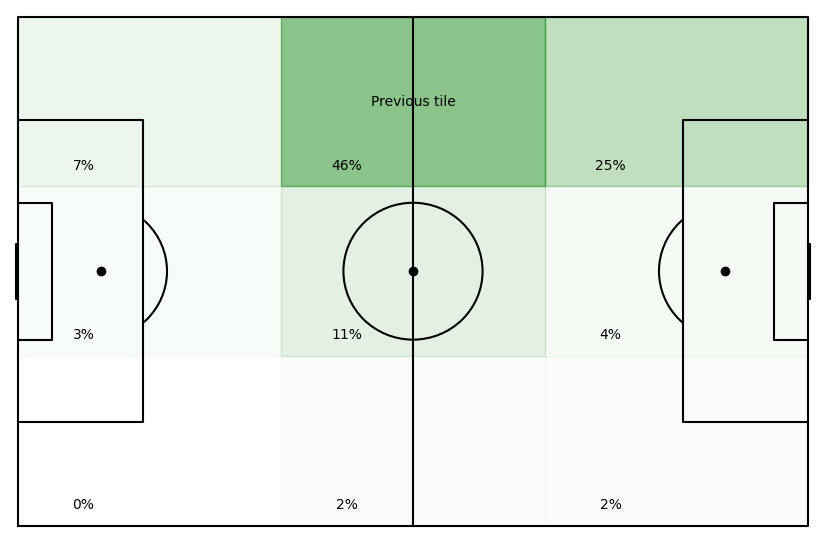

In [23]:
draw_pitch("white", "black", prob, decoded_indices[-1])

##### Case 3

This is an example of an incorrect prediction.

As can be seen from the graph, the model outputs box 6 as the next tile where the ball will be, however, in reality, the ball will remain in tile 7.

As mentioned before, however, the model is still able to output the actual tile as the second alternative; in fact, the actual tile where the ball will be is only 8 percentage points away from the label with the highest value (tile 6).

In [24]:
decoded_indices = np.argmax(X_test[45], axis=1)

decoded_indices = decoded_indices[decoded_indices != 9]
print("Pass chain:", decoded_indices)

Pass chain: [0 5 1 4 2 5 5 3 7]


In [25]:
# Find the index of the maximum value in each one-hot encoded vector (representing the original class)
decoded_index = np.argmax(y_test[45], axis=0)

decoded_index = decoded_index[decoded_index != 9]
print("Expected result:", decoded_index)

Expected result: [7]


In [26]:
# in case you are using the loaded model, do not change the method, otherwise change it to "predict_probab"
predictions = model.predict(np.expand_dims(X_test[45], axis=0))
predictions = np.delete(predictions, -1)

prob = predictions.tolist()
prob = [round(x, 2) for x in prob]

1/1 [==============================] - 0s 64ms/step


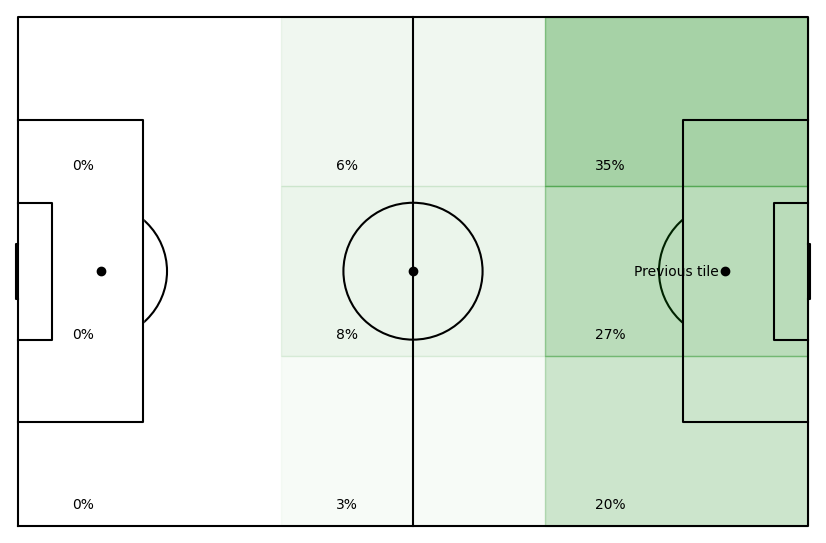

In [27]:
draw_pitch("white", "black", prob, decoded_indices[-1])